In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e1/sample_submission.csv
/kaggle/input/playground-series-s3e1/train.csv
/kaggle/input/playground-series-s3e1/test.csv


In [9]:
train_data = pd.read_csv("/kaggle/input/playground-series-s3e1/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s3e1/test.csv")
submission_data = pd.read_csv("/kaggle/input/playground-series-s3e1/sample_submission.csv")

In [153]:
train_data = train_data[train_data["MedHouseVal"]<=5]

In [6]:
train_data[train_data["MedHouseVal"]==5.00001]

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
18,18,12.4118,18.0,8.863081,1.112082,1288.0,3.050392,34.04,-118.90,5.00001
83,83,9.4894,38.0,7.434426,1.032787,654.0,2.893443,34.07,-118.34,5.00001
108,108,4.0911,39.0,5.324324,1.110811,1501.0,2.053245,33.62,-117.87,5.00001
109,109,15.0001,17.0,8.642586,1.027739,1674.0,3.311518,34.15,-118.83,5.00001
120,120,5.2337,31.0,4.964286,1.088537,871.0,2.189024,34.07,-118.40,5.00001
...,...,...,...,...,...,...,...,...,...,...
37038,37038,6.3749,22.0,4.834667,0.984000,1179.0,2.996000,33.86,-118.40,5.00001
37060,37060,8.0753,36.0,7.411111,1.068627,1705.0,2.936255,33.99,-118.43,5.00001
37061,37061,7.1615,45.0,7.098361,1.018305,823.0,2.504673,37.58,-122.34,5.00001
37066,37066,10.2311,52.0,8.592308,1.461538,191.0,1.692308,37.79,-122.39,5.00001


In [155]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
valid_cols = ['MedInc','HouseAge', 'AveRooms', 'AveBedrms', 'Population','AveOccup','Latitude','Longitude']
x = train_data[valid_cols]
norm_x = scaler.fit_transform(x)

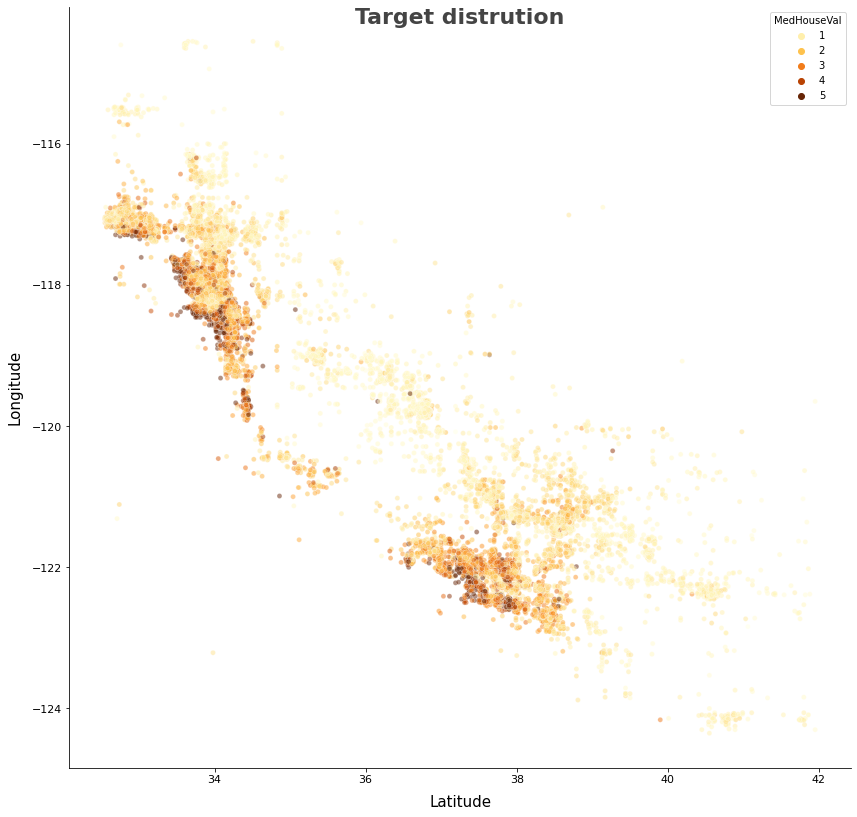

In [152]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 14))
plt.title('Target distrution', size=22, y=0.97, fontname='Calibri', 
          fontweight='bold', color='#444444')
a = sns.scatterplot(data=train_data, x='Latitude', y='Longitude', hue='MedHouseVal', 
                    palette=sns.color_palette('YlOrBr', as_cmap=True), s=25, alpha=0.5)
plt.xticks(size=11)
plt.yticks(size=11)
plt.xlabel('Latitude', labelpad=10, fontsize=15)
plt.ylabel('Longitude', labelpad=10, fontsize=15)

for j in ['right', 'top']:
    a.spines[j].set_visible(False)
    
plt.show()

<AxesSubplot:xlabel='MedHouseVal', ylabel='Count'>

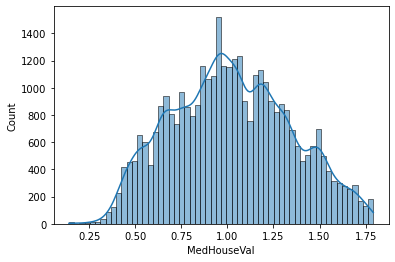

In [154]:
import seaborn as sns
# sns.histplot(data=train_df, x="MedHouseVal",kde=True)
sns.histplot(data=np.log1p(train_data["MedHouseVal"]),kde=True)

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class RegModel(nn.Module):
    def __init__(self, in_dim, hidden_dim,out_dim=1):
        super( RegModel, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        self.act = nn.ReLU()
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        return x

In [156]:
x = torch.FloatTensor(norm_x)
y = torch.FloatTensor(np.log1p(train_data["MedHouseVal"]).values)

In [176]:
model = RegModel(x.shape[1], 128)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-4)
batch_size=32
model  

RegModel(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (act): ReLU()
)

In [177]:
from sklearn.model_selection import KFold
k_fold = KFold(3)
for k, (train, test) in enumerate(k_fold.split(x, y)):
    for i in range(500):
        pred_y = model(x[train])
        loss = criterion(pred_y.squeeze(dim=1), y[train])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%50==0:
            print(f"train loss is {loss}")
            pred_y = model(x[test])
            loss = criterion(pred_y.squeeze(dim=1), y[test])
            print(f"test loss is {loss}")       

train loss is 1.167706847190857
test loss is 1.1589972972869873
train loss is 0.6706482172012329
test loss is 0.6653309464454651
train loss is 0.3254212737083435
test loss is 0.3225098252296448
train loss is 0.14978432655334473
test loss is 0.14939060807228088
train loss is 0.10373064130544662
test loss is 0.10441005975008011
train loss is 0.09596291929483414
test loss is 0.09660612046718597
train loss is 0.0907476618885994
test loss is 0.09129732102155685
train loss is 0.08487114310264587
test loss is 0.0853591188788414
train loss is 0.07882963865995407
test loss is 0.0792468935251236
train loss is 0.072551429271698
test loss is 0.07289600372314453
train loss is 0.06664968281984329
test loss is 0.06634644418954849
train loss is 0.06065183877944946
test loss is 0.06042112410068512
train loss is 0.055462878197431564
test loss is 0.05527985095977783
train loss is 0.05140009522438049
test loss is 0.05124792829155922
train loss is 0.04840562865138054
test loss is 0.04826992005109787
train 

In [51]:
test_data

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,37137,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85
1,37138,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29
2,37139,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81
3,37140,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34
4,37141,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29
...,...,...,...,...,...,...,...,...,...
24754,61891,2.2875,34.0,3.914729,1.085271,866.0,2.071429,34.44,-119.75
24755,61892,3.0781,33.0,4.771971,1.038674,1628.0,2.326848,34.09,-117.96
24756,61893,2.6961,14.0,4.593960,1.170380,3900.0,2.540034,37.51,-120.83
24757,61894,7.2315,8.0,7.508403,1.018692,1388.0,2.601202,33.67,-117.98


In [178]:
test_x = test_data[valid_cols]
norm_test_x = scaler.transform(test_x)

In [179]:
norm_test_x = torch.FloatTensor(norm_test_x )
pred_y = model(norm_test_x)
pred_y

tensor([[0.4681],
        [0.7984],
        [1.4912],
        ...,
        [0.8002],
        [1.4233],
        [1.3880]], grad_fn=<AddmmBackward0>)

In [180]:
test_y = np.expm1(pred_y.data.numpy())
test_y

array([[0.5970291],
       [1.222004 ],
       [3.4424791],
       ...,
       [1.226011 ],
       [3.1509519],
       [3.0066688]], dtype=float32)

In [183]:
submission_data["MedHouseVal"] = test_y
submission_data.loc[submission_data["MedHouseVal"]<0, "MedHouseVal"] = 0.14999
submission_data.to_csv("baseline.csv", index=False)